In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We need two files.  Both are located in the current working directory.
1. The actual data itself, exported from Qualtrics -- `Linguistic Listening Survey....csv`
1. A mapping between the questions and conditions -- `mcdermott_code.csv`

We'll load both of them as `pandas` dataframes.  For the actual data, there are many fields we won't need, so I will delete them.  Some of these, in particular the textual information about region and language experience, you may want to restore in the future.

In [2]:
codedf = pd.read_csv('./mcdermott_code.csv')
datadf = pd.read_csv('./Linguistic Listening Survey_April 18, 2019_10.11.csv')

# Drop columns we don't need
datadf = datadf.drop(['StartDate','EndDate','Status','IPAddress','Progress','Finished','RecordedDate',
                      'RecipientLastName','RecipientFirstName','RecipientEmail','ExternalReference',
                      'LocationLatitude','LocationLongitude','DistributionChannel','UserLanguage',
                      'Q1','Q6','Q87','Q88',
                      'Q2_8_TEXT', 'Q2_9_TEXT','Q4_2_TEXT','Q4_3_TEXT'  # these you may wish to restore later
                     ],1)
# Drop rows we don't need (the first two rows in the data are descriptive information, which we don't need)
datadf = datadf.drop([0,1],0)

Let's have a peek!

In [3]:
datadf.head()

,Duration (in seconds),ResponseId,Q2,Q3,Q4,Q5,Q7,Q8,Q9,Q10,...,Q115,Q116,Q117,Q118,Q119,Q120,Q121,Q122,Q123,Q124
2,46,R_2tyQLD1gFeoi9aC,NaN,NaN,NaN,NaN,1,2,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,863,R_3hm88sJfrqS9fEP,1,22,NaN,yes - major,1,2,2,1,...,2,1,NaN,NaN,1,2,2,1,NaN,NaN
4,915,R_1jTgG3U8AebIJia,7,38,NaN,yes,1,2,1,1,...,2,1,2,2,1,2,2,2,1,NaN
5,910,R_3fyocno9SZdXZW9,9,24,1,No,1,2,1,1,...,2,1,1,1,1,2,2,1,1,3
6,720,R_1E4LZRzmh4Vld5R,8,21,3,No,1,2,2,1,...,2,1,1,1,1,2,1,1,1,3


Notice that many columns have names that aren't very descriptive (e.g. `Q2`) or are very long (e.g. `Duration (in seconds)`).  We'll rename these to be more user friendly.

In [4]:
datadf = datadf.rename(index=str, columns={'Duration (in seconds)':'Duration'})
datadf = datadf.rename(index=str, columns={'Q2':'region', 'Q3':'age', 'Q4':'language', 'Q5':'linguistics','Q124':'recognize'})
datadf.head()

,Duration,ResponseId,region,age,language,linguistics,Q7,Q8,Q9,Q10,...,Q115,Q116,Q117,Q118,Q119,Q120,Q121,Q122,Q123,recognize
2,46,R_2tyQLD1gFeoi9aC,NaN,NaN,NaN,NaN,1,2,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,863,R_3hm88sJfrqS9fEP,1,22,NaN,yes - major,1,2,2,1,...,2,1,NaN,NaN,1,2,2,1,NaN,NaN
4,915,R_1jTgG3U8AebIJia,7,38,NaN,yes,1,2,1,1,...,2,1,2,2,1,2,2,2,1,NaN
5,910,R_3fyocno9SZdXZW9,9,24,1,No,1,2,1,1,...,2,1,1,1,1,2,2,1,1,3
6,720,R_1E4LZRzmh4Vld5R,8,21,3,No,1,2,2,1,...,2,1,1,1,1,2,1,1,1,3


We need to transform this data so that each row is a single "observation" -- that is, each row must represent a single response from a single participant.  To do this, we'll use the `melt` function from `pandas`, retaining these fields for each observation:
- ResponseId -- the unique ID assigned to each participant
- Duration -- the amount of time each participant took (for the whole survey)
- region -- the region coding
- age -- their age
- language -- whether English is their native language or not
- linguistics -- whether they have experience with Linguistics
- recognize -- whether they recognize the speakers in the study
`melt` produces two new columns, called `variable` and `value`, which we will rename to `question` and `response`.

In [5]:
responsedf = datadf.melt(id_vars =['ResponseId','Duration','region','age','language',
                                   'linguistics','recognize']).rename(index=str, columns={'variable':'question','value':'response'})
responsedf.head()

,ResponseId,Duration,region,age,language,linguistics,recognize,question,response
0,R_2tyQLD1gFeoi9aC,46,NaN,NaN,NaN,NaN,NaN,Q7,1
1,R_3hm88sJfrqS9fEP,863,1,22,NaN,yes - major,NaN,Q7,1
2,R_1jTgG3U8AebIJia,915,7,38,NaN,yes,NaN,Q7,1
3,R_3fyocno9SZdXZW9,910,9,24,1,No,3,Q7,1
4,R_1E4LZRzmh4Vld5R,720,8,21,3,No,3,Q7,1


Now let's have a look at the mapping dataframe.  There are 7 fields:
1. question -- the Qualtrics ID of each question of interest
1. voice -- the audio file associated with the question, which are coded by speaker
1. type -- is it a word or a phrase that the listener's responding to?
1. r_ness -- your qualitative judgement of whether there is an /r/ present in the recording
1. word -- the name of the word (this will be useful for comparing the word vs. phrase judgements directly)
1. word_real -- this is the English word form associated with the /r/
1. r_spelling -- which response (1 or 2) is associated with having heard the /r/

In [6]:
codedf.head()

,question,voice,type,r_ness,word,word_real,r_spelling
0,Q99,K46,Phrase,partial,Ainkarka,Car,2
1,Q123,J35,Phrase,full,Alayner,Alaina,2
2,Q89,J11,Phrase,none,Anmisterthee,Mister,2
3,Q95,J17,Phrase,none,Atharfav,Other,2
4,Q108,K56,Phrase,partial,Baror,Bar,1


We need to merge this information with the response data, which we will do with the `merge` function in `pandas`.  We will specify that the column they have in common is `question`, and setting the merge to `outer` means we will only get the intersection of the two dataframes.  In other words, we will only get information about the questions that were not fillers.

In [7]:
responsedf = pd.merge(responsedf, codedf, on='question', how='outer')
responsedf.head()

,ResponseId,Duration,region,age,language,linguistics,recognize,question,response,voice,type,r_ness,word,word_real,r_spelling
0,R_2tyQLD1gFeoi9aC,46,NaN,NaN,NaN,NaN,NaN,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0
1,R_3hm88sJfrqS9fEP,863,1,22,NaN,yes - major,NaN,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0
2,R_1jTgG3U8AebIJia,915,7,38,NaN,yes,NaN,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0
3,R_3fyocno9SZdXZW9,910,9,24,1,No,3,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0
4,R_1E4LZRzmh4Vld5R,720,8,21,3,No,3,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0


Let's determine whether the subject heard an /r/ or not.  We can use the `apply` function to check whether the participant's response matched the option for /r/ spelling.  I have coded this as `0` for if no /r/ was heard, and `1` for if /r/ was heard.  In the cells to come, this will allow us to take the mean of these values to get what percentage of the participants perceived an /r/ for any given stimulus item.

In [8]:
responsedf['r_heard'] = responsedf.apply(lambda x: 1 if float(x['response'])==x['r_spelling'] else 0, axis=1)
responsedf.head()

,ResponseId,Duration,region,age,language,linguistics,recognize,question,response,voice,type,r_ness,word,word_real,r_spelling,r_heard
0,R_2tyQLD1gFeoi9aC,46,NaN,NaN,NaN,NaN,NaN,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0,0
1,R_3hm88sJfrqS9fEP,863,1,22,NaN,yes - major,NaN,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0,0
2,R_1jTgG3U8AebIJia,915,7,38,NaN,yes,NaN,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0,0
3,R_3fyocno9SZdXZW9,910,9,24,1,No,3,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0,0
4,R_1E4LZRzmh4Vld5R,720,8,21,3,No,3,Q7,1,J1,Word,none,Anmisterthee,Alaina,2.0,0


From here, there are _lots_ of different ways you can start to look at this data.  Here is just one of many.

We can create a grouped dataframe, taking the mean of the `r_heard` values for every combination of a set of factors.  Here, I've chosen these factors:
- region -- the manipulation here is for where people grew up, so we should definitely keep this
- ResponseId -- this keeps each subject separate
- type -- keeps the words and phrases separate
- r_ness -- keeps the three qualitative levels of /r/ presence separate

This, therefore, aggregates over the all of the words within each type and r_ness combination.

In [9]:
grouped = responsedf.groupby(['region','ResponseId','type','r_ness'],as_index=False).aggregate(np.mean)
grouped.head()

,region,ResponseId,type,r_ness,r_spelling,r_heard
0,1,R_1N5rQgL96iuxnGj,Phrase,full,1.857143,0.142857
1,1,R_1N5rQgL96iuxnGj,Phrase,none,1.562500,0.312500
2,1,R_1N5rQgL96iuxnGj,Phrase,partial,1.545455,0.454545
3,1,R_1N5rQgL96iuxnGj,Word,full,1.833333,1.000000
4,1,R_1N5rQgL96iuxnGj,Word,none,1.588235,0.058824


In [10]:
grouped.to_csv('./results.csv')

Finally, let's have a look at the responses.

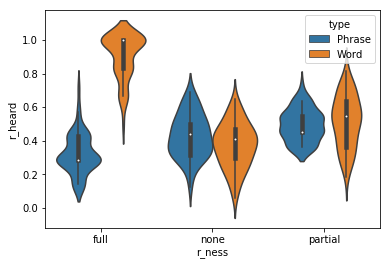

In [19]:
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped,x_order=['none','partial','full'])

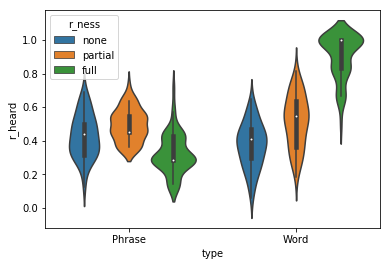

In [21]:
sns.violinplot(x='type',y='r_heard',hue='r_ness',data=grouped,hue_order=['none','partial','full'])

Text(0.5,1,'other')

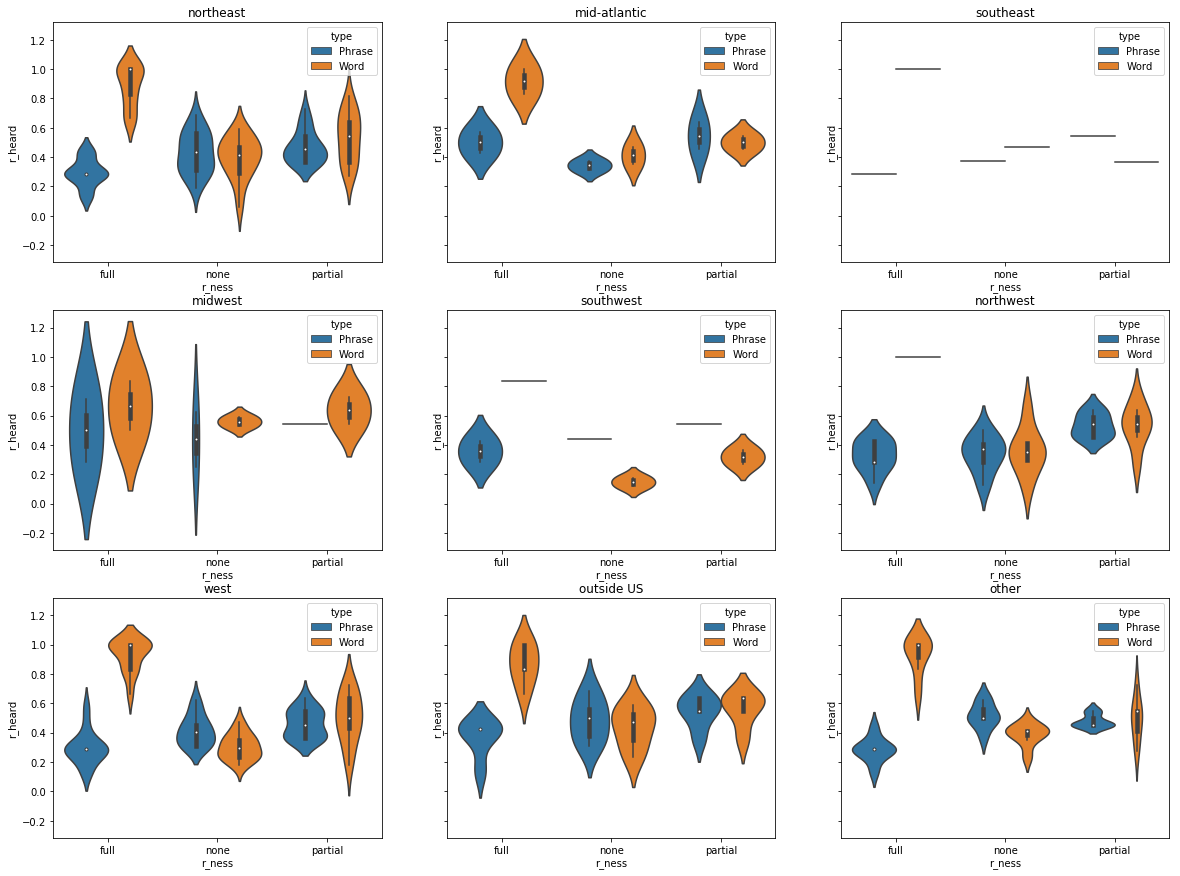

In [13]:
fig, axs = plt.subplots(3,3,figsize=(20, 15), sharey=True)

sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='1'], ax=axs[0,0]).set_title('northeast')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='2'], ax=axs[0,1]).set_title('mid-atlantic')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='3'], ax=axs[0,2]).set_title('southeast')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='4'], ax=axs[1,0]).set_title('midwest')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='5'], ax=axs[1,1]).set_title('southwest')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='6'], ax=axs[1,2]).set_title('northwest')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='7'], ax=axs[2,0]).set_title('west')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='8'], ax=axs[2,1]).set_title('outside US')
sns.violinplot(x='r_ness',y='r_heard',hue='type',data=grouped[grouped.region=='9'], ax=axs[2,2]).set_title('other')